<a href="https://colab.research.google.com/github/edoardochiarotti/class_datascience/blob/main/2023/07_Endogeneity/Resources/07_Endogeneity.ipynb"
   target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Endogeneity

<img src="https://i.imgflip.com/84g5gd.jpg" width="500">

In [1]:
# PACKAGES
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import statistics as st
import pandas as pd
import os
import statsmodels.api as sm
import re
!pip install stargazer
from stargazer.stargazer import Stargazer

# FUNCTIONS FROM PACKAGES
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

# SEABORN THEME
scale = 0.4
W = 16*scale
H = 9*scale
sns.set(rc = {'figure.figsize':(W,H)})
sns.set_style("white")

- In this class we'll cover endogeneity in general, with a focus on omitted variable bias and interaction terms.
- This class is based on several **sources**. The main one are the class notes by Nicolas Berman and Daniele Rinaldo at The Geneva Graduate Institute.

## Outline
- [Omitted-Variable Bias](#Omitted-Variable-Bias)
- [Omitted Variables in Python](#Omitted-Variables-in-Python)
- [Other Sources of Endogeneity](#Other-Sources-of-Endogeneity)
- [Interaction Terms](#Interaction-Terms)
    - [Visualizing Interaction Terms](#Visualizing-Interaction-Terms)
    - [Interaction Terms in a Regression Setup](#Interaction-Terms-in-a-Regression-Setup)
    - [Interaction Terms in the Level-Level Model](#Interaction-Terms-in-the-Level-Level-Model)

## Omitted-Variable Bias <a name="Omitted-Variable-Bias"></a>
- In the previous class we considered the assumptions of the linear regression model for the OLS to be a good estimator, namely:
    1. **Linearity**: $\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$
    2. **Full rank**: $\boldsymbol{X}$ is full rank, i.e. there is no exact linear relationship among any of the independent variables in the model.
    3. **Exogeneity of the independent variable**: $ \mathrm{E}(\boldsymbol{\epsilon}|\boldsymbol{X})=\boldsymbol{0}$. This implies $\mathrm{E}(\boldsymbol{y}|\boldsymbol{X}) = \boldsymbol{X}\boldsymbol{\beta}$.
    4. **Homoscedasticity and nonautocorrelation**: $\mathrm{V} (\boldsymbol{\epsilon}|\boldsymbol{X})=\sigma^2\boldsymbol{I}_N$. If we consider assumption 3, this assumption can be re-written as $\mathrm{E}(\boldsymbol{\epsilon}'\boldsymbol{\epsilon}|\boldsymbol{X}) = \sigma^2\boldsymbol{I}_N$.
    5. **Data generation**: $\boldsymbol{X}$ may be fixed or random.
    6. **Normal distribution**: $\boldsymbol{\epsilon}|\boldsymbol{X}$ is normally distributed.
- In econometrics, instead of saying good we say "**unbiased**", i.e. the mean of the estimator is the parameter of interest. Also, under assumption 4 (that is usually referred to as "spherical disturbances"), we say that the OLS estimator is also the most **efficient among** all estimators, i.e. it has the smaller variance. Formally this implication is called the **Gauss-Markov theorem**, i.e. under assumptions 1-6 the OLS estimator is the Best Linear Unbiased Estimator (BLUE).
- These implied properties of the OLS estimator (unbiased and efficient) are usually referred to as the **small-sample properties** of the OLS estimator. On that basis, econometrics then uses **asymptotic theory** to extend such properties to large sample. In a nutshell, when the sample size is large, we need less-stringent assumptions than 1-6 to claim that the OLS is consistent (which is the large-sample version of unbiased). For example, in large samples we only need a weak endogeneity of the independent variables, expressed as $\mathrm{E}(\boldsymbol{\epsilon}\boldsymbol{X})$ (rather than $\mathrm{E}(\boldsymbol{\epsilon}|\boldsymbol{X})=\boldsymbol{0}$)), for the estimator to the consistent.
- The exogeneity assumption is by far the most important one. Whenever it fails, i.e. whenever some of the regressors are correlated with the error term, the OLS estimator is **biased** (or inconsistent in large samples). The problem comes from the fact that the OLS estimator assigns to some of the regressors the effect of changes in the error terms which are correlated with these regressors. This can arise for several reasons, namely omitted variables, simultaneity / reverse causality, error-in-variables / measurement error, and sample selection. 
- Let's discuss the bias arising from **omitted variables**. A common failure of the assumption on the exogeneity of the independent variable is when a relevant variable is omitted. We can illustrate the bias that it might cause using the simple regression model. Assume that the model of the data generating process (and also of the population), has 2 regressors:
<br><br>
$$
y_i = \beta_0 + x_{1i}\beta_1 + x_{2i}\beta_2 + \epsilon_i
$$
<br>
- If we estimate only $y_i = \beta_0 + x_{1i}\beta_1 + \epsilon_i$ with OLS, then it can be shown that
<br><br>
$$
\mathrm{E}(\hat{\beta}_{1,OLS}) = \beta_1 + \beta_2 \frac{\sum_{i=1}^{N}(x_{1i}-\overline{x})x_{2i}}{(x_{1i}-\overline{x})^2}
$$
<br>
- Omitting the variable $x_2$ therefore leaves the estimate of the coefficient $\beta_1$ unbiased if either of the two following **conditions** are satisfied: 
    - the partial effect of $x_2$ is zero in the sample, i.e. the estimate of $\beta_2$ is not statistically different from zero (which means it that the model omitting $x_2$ is actually well specified); 
    - $x_1$ and $x_2$ are uncorrelated in the sample, i.e. the factor after $\beta_2$ in the equation is zero (you should have noticed that that factor would be the coefficient estimate of a regression of $x_2$ on $x_1$).
- As soon as $x_2$ has some effect on the dependent variable and is correlated with $x_1$ to some extent, there will be an omitted variable bias. It is therefore important, when thinking about potential omitted variable, to try to determine whether they are likely to be correlated with the included regressors. Omitting a variable which is uncorrelated with the regressors is not a problem. After all, there will always be some of such variables in the error term.
- When $\mathrm{E}(\hat{\beta}_{1,OLS}) > \beta_1$ we say that there is **upward bias** (the coefficient is “too high”). When $\mathrm{E}(\hat{\beta}_{1,OLS}) < \beta_1$ we say that there is a **downward bias**. Intuition should allow you to determine whether the coefficients are biased upward or downward. For example, let's consider our analysis of the income, proxied by GDP per capita, on CO2 emissions per capita. In our analysis, the coefficient estimate of 1.3136 tells us that, on average, if GDP per capita increases by 1%, we'd expect CO2 emissions per capita to increase by 1.3136%. Let's think of a omitted variable that would make this estimate biased. Maybe **carbon taxes**? If countries with high income per capita also have high carbon tax, then individuals are somehow constrained in the amount of environmentally-damaging goods they can buy. Without any carbon tax, they would buy even more of these goods, and thus emit even more. So, if we do not control for carbon taxes, i.e. if we do not keep them constant, we might be underestimating the real effect of income on climate change (downward bias). Let's analyze in order our 2 conditions to see if a tax on carbon could be an omitted variable here:
    - Correlation between carbon taxes ($x_2$) and GDP per capita ($x_1)$: it could be that countries with higher GDP per capita could also have higher carbon taxes, as the institutions in those countries are "more developed" and therefore have already implemented high carbon taxes to fight climate change.
    - Correlation between carbon taxes ($x_2$) and CO2 emissions per capita ($y$): it could be that higher carbon taxes lead to less emissions because with a carbon tax either people or firms consume less environmentally-intensive goods (like oil etc).

<img src="https://i.imgflip.com/84g6uu.jpg" width="500">

## Omitted Variables in Python <a name="Omitted-Variables-in-Python"></a>
- OK let's see what happens when we include a proxy for carbon taxes. In **QoG**, we have `oecd_cctr_gdp`, which is the climate change-related tax revenue as a percentage of gross domestic product (GDP). Includes taxes, fees and charges, tradable permits, deposit-refund systems, subsidies, and voluntary approaches related to the domain of climate change. We would also have a variable for taxes on oil, but it's available only for a very limited number of countries in combination with out other variables. Let's load the data as before and make a cross section by dropping outliers:

In [2]:
# get data
link = "https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx"
df_qog = pd.read_excel(link)

In [3]:
# get variables
indexes = ["ccodealp","year"]
variabs_co2 = ["edgar_co2gdp","edgar_co2t","edgar_co2pc"]
variabs_control = ["oecd_cctr_gdp"]
variabs = variabs_co2 + variabs_control
df = df_qog.loc[:,np.append(indexes,variabs)]

# make gdp per capita
df["gdp"] = (df["edgar_co2gdp"]/df["edgar_co2t"])**(-1) # billions US dollars
df["pop"] = (df["edgar_co2pc"]/df["edgar_co2t"])**(-1) # millions
df["gdp_pc"] = df["gdp"]/df["pop"] # thousands of US dollars
variabs = np.append(variabs, ["gdp","pop","gdp_pc"])

In [4]:
# make cross section
df = df.groupby("ccodealp")[variabs].mean().reset_index().dropna()

# put ones into data
df["ones"] = 1

# drop outliers quick and dirty
df = df.loc[df["gdp_pc"] < 80,:]

# maybe logs?
df["ln_gdp_pc"] = np.log(df["gdp_pc"])
df["ln_edgar_co2pc"] = np.log(df["edgar_co2pc"])

In [5]:
df.describe()

,edgar_co2gdp,edgar_co2t,edgar_co2pc,oecd_cctr_gdp,gdp,pop,gdp_pc,ones,ln_gdp_pc,ln_edgar_co2pc
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0,94.000000,94.000000
mean,0.247688,197.785266,4.579651,73.014182,656.536134,43.151156,18.413256,1.0,2.464158,0.763608
std,0.171519,724.483234,4.642850,33.044395,1942.761018,157.634505,15.620912,0.0,1.063199,1.489884
min,0.025149,0.108556,0.045539,0.000000,0.972423,0.079685,0.983474,1.0,-0.016665,-3.089184
25%,0.155541,2.874297,0.823145,61.070963,24.786033,2.805962,5.621943,1.0,1.725947,-0.195291
50%,0.206411,17.087489,2.565880,88.027040,88.232740,8.409836,14.566397,1.0,2.678591,0.920825
75%,0.280579,80.662085,7.670111,97.768910,403.598555,21.942667,27.169305,1.0,3.300853,2.037271
max,0.935758,5229.757152,19.800997,100.000000,15228.525307,1183.106459,66.130154,1.0,4.191625,2.985732


- By looking at the summary statistics, we notice that actually `oecd_cctr_gdp` is probably not in percentage of GDP, but it looks like it has been normalized between 0 and 100, by some rule. For the scope of this exercise, we will not investigate this aspect further and we'll assume that this normalization is correct.
- Let's use the canned routine `sm.OLS.from_formula` to study what happens when we include the new regressor revenues from carbon-related taxes `oecd_cctr_gdp`. First, let's re-run the model with GDP per capita only:

In [6]:
# canned ols
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc', df).fit()
ols_canned_results_table = ols_canned_results.summary().tables[1]
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


- OK same coefficient estimate of before of 1.3136 - so a 1% increase in GDP per capita leads to a 1.3136% increase in CO2 emissions per capita. Let's now include tax revenues. Remember, we expect that when we do not include revenues from carbon-related taxes we are underestimating the coefficient of GDP per capita. So when we include revenues from carbon-related taxes, it's as if we are controlling for it, i.e. we keep it constant, and the coefficient of GDP should therefore increase (if we are right). Let's try:

In [7]:
# canned ols
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp', df).fit()
ols_canned_results_table = ols_canned_results.summary().tables[1]
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.3660,0.167,-14.131,0.000,-2.699,-2.033
ln_gdp_pc,1.3245,0.052,25.575,0.000,1.222,1.427
oecd_cctr_gdp,-0.0018,0.002,-1.102,0.273,-0.005,0.001


- OK so almost as expected. First of all, the coefficient estimate of **GDP per capita** indeed increased from 1.3136 to 1.3245 - and looking at the p-value we can infer that the population parameter is different from zero, and that the probability that we are being wrong when making this claim (inference) is lower than 1%. From now on, we can summarize all this by saying that results are statistically significant at the 1-% level. Second, the coefficient of the **revenues from carbon-related taxes** is indeed negative, indicating that countries with higher tax rates on carbon have lower emissions. However, the p-value of this coefficient estimate is 0.273, which means that this result is not statistically significant even at the 10-% level. In short, based on our sample, we cannot say that the effect of carbon-related taxes on CO2 emissions per capita is different than zero.
- As the coefficient estimate is not statistically significant, excluding this regressor from our regression should not bias our estimate for the coefficient of the natural logarithm of GDP per capita. But still we did see that this coefficient estimate nonetheless increased when we included carbon-related taxes. So which **specification** is the correct, with or without carbon-related taxes? 
- One more thing we can check is whether the fit of our model changed or not. To do that we need to check the **R-Squared**. As we did not implement the R-Squared in our functions (we could have, but we got lazy), let's use again the canned routine and have a look with the stargazer package:

In [8]:
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc', df).fit()
ols_canned_results_tax = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp', df).fit()
stargazer = Stargazer([ols_canned_results, ols_canned_results_tax])
stargazer

- The R-Squared increases marginally. This table also reports the adjusted R-Squared and the F statistic. As the R-Squared by construction increases as we add regressors, the **adjusted R-Squared** does not (for more information, see Green). So as also the adjusted R-Squared increases marginally, we can say that this small increase reflects an actual improvement in the fit of the model, and not the fact that we have added another regressor. Finally the **F statistic** is a test statistic for the joint significance of the regressors. As we included carbon-related taxes, this t-statistic largely decreased. However, it still remains high (3 starts are still there), so we might think that even with the carbon-related taxes the coefficient estimates are jointly significant at the 1% level.
- So **conclusion**: should we keep or not carbon-related taxes in the regression? There is no real way to decide, and it's a bit up to us. Specifically, in this sample it is not a large source of omitted-variable bias, so we can drop it. In general, omitting it might lead to omitted-variable bias in other samples, so we might want to keep it.

## Other Sources of Endogeneity <a name="Other-Sources-of-Endogeneity"></a>
- In this class we won't have time to go through the other sources of endogeneity in Python. Let's quickly mention them here.
- **Simultaneity / reverse causality**. The omitted variable case is not the only one: the error term can be correlated with the regressors when there is reverse causality (or simultaneity), i.e. whenever the dependent variable has a direct effect on the regressors. Imagine for instance that you want to test the effect of financial development on economic growth. There might be a reverse causality problem, as economic growth positively affects demand for credit and the size of the financial system. This causes correlation between the error term and the regressors: when the error term increases, it will increase financial development.
- **Error-in-variables**. Let's assume our single-regressor model is $y = \beta x + v$. Imagine that instead of $x$, you observe $\breve{x} = x + \epsilon$: the regressor is observed with error. Assume that this error is uncorrelated with $x$, $y$ and $v$: $\mathrm{E}(ve)=\mathrm{E}(xe)=\mathrm{E}(ye)=0$. This is a very common problem, and is called classical measurement error. We can rewrite our model as $y = \beta(\breve{x}-\epsilon)+v=\beta \breve{x}+(v-\beta\epsilon)$. Part of the error term now contains $\epsilon$: as $\breve{x}$ and $\epsilon$ are positively correlated, the OLS estimation will generate a negative bias in $\hat{\beta}$ if the true $\beta$ is positive, and a positive bias if the true $\beta$ is negative. The non-classical measurement error, i.e. cases where $\mathrm{E}(xe)\neq 0$, exacerbates the problem.
- **Sample selection**. The general idea is that the correlation between the error term and the regressors might come from the way in which the sample is constructed or selected.

<img src="https://i.imgflip.com/84g761.jpg" width="500">

## Interaction Terms <a name="Interaction-Terms"></a>
- So far we have estimated the population model $ln\_edgar\_co2pc = \beta_0 + ln\_gdp\_pc\beta_1 + oecd\_cctr\_gdp\beta_2 + \epsilon$. We did it because we believe that countries with high GDP per capita might also have higher carbon taxes, and if we do not control for the latter we might be underestimating our coefficient of interest, as with high taxes individuals are not free to consume as much as they wanted to. By including carbon-related taxes in our model, we were able to estimate the effect of GDP per capita on CO2 emissions per capita by keeping carbon-related taxes constant. We have seen that results do not change much.
- Let us now ask ourselves a slightly different question. Do we have reasons to believe that the effect of GDP per capita on CO2 emissions might change as carbon-related taxes increase? Maybe. Indeed, to motivate the direction of the potential bias, we said that without any carbon tax people might buy even more carbon-intensive goods, and thus emit even more. So what we are saying is that **our channel might be even stronger** in countries with low carbon taxes, with respect to others.
- Note that here our logic is slightly different than the one we used to think about omitted-variable bias. Indeed, the source of omitted-variable bias had to meet 2 conditions, i.e. (i) $x_2$ is correlated to $x_1$, (ii) $x_2$ itself explains $y$. Now, we are thinking about an $x_2$ that meets 2 slightly different conditions, i.e (i) $x_2$ is correlated to $x_1$, (ii) the interaction between $x_2$ and $x_1$ explains $y$. I am saying this because even if a variable is not necessarily a source of omitted-variable bias, its interaction with another regressor may still help explaining the variation of our dependent variable, so we still may want to model such interaction. This links to what our own Quentin did in his article in Towards Data Science. When we thought about rain as a possible source of heterogeneity, he did not worry about whether rain itself explained the stringency of environmental regulations. Differently, what he thought is that maybe the fact that heat waves make policy makers more aware of climate change (and therefore they make laws about it) is even more straightforward in countries where it does not rain, regardless of whether rain itself can change the opinion of policymakers about climate change. Cool.
- OK so since we are interested about how the impact of GDP per capita on CO2 emissions per capita might change at different level of carbon taxes, let's model it shall we? We do so with an **interaction term**.

### Visualizing Interaction Terms <a name="Visualizing-interaction-Terms"></a>
- Graphically, we can visualize such interaction by creating a binary variable that equals 0 for countries with low carbon tax and 1 for countries with high carbon tax. For example, we can use the median as a the splitting threshold. Let's do it:

In [9]:
median = df['oecd_cctr_gdp'].median()
df['dummy_oecd_cctr_gdp'] = df['oecd_cctr_gdp'] >= median
df["dummy_oecd_cctr_gdp"] = df["dummy_oecd_cctr_gdp"].astype(int)

- OK so our main channel is that countries with higher GDP per capita have higher CO2 emissions per capita. As carbon taxes do not allow people to consume as much carbon-intensive goods as they want, we expect our channel to be less strong in countries where carbon taxes are high. Translated, we expect our regression line to be less steep in countries that have an above-median carbon tax.
- So first we need to make a graph in which we differentiate **below-median and above-median countries**:

<AxesSubplot:xlabel='ln_gdp_pc', ylabel='ln_edgar_co2pc'>

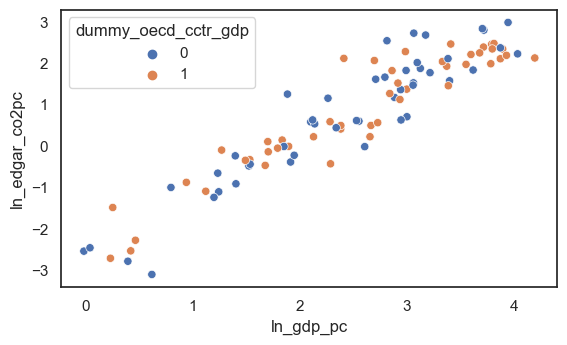

In [10]:
sns.scatterplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df, hue="dummy_oecd_cctr_gdp")

- OK it looks like indeed the cloud of countries below median (blue) follows a slightly steeper upward trend than countries below the median (orange). Let's plot the OLS fit lines using `lmplot`:

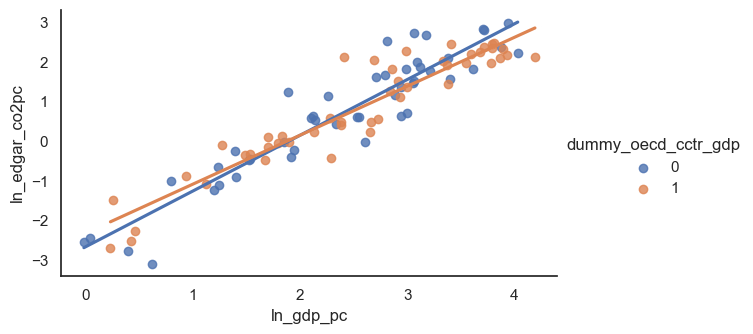

In [11]:
sns.lmplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df, hue="dummy_oecd_cctr_gdp", height=3.5, aspect=1.7, ci=False)

- Yep indeed. The blue line is slightly steeper than the orange line. That means that, on average, the impact of GDP per capita on CO2 emissions per capita might be lower (fit line is less steep) in countries with higher carbon tax.

### Interaction Terms in a Regression Setup <a name="Interaction-Terms-in-a-Regression-Setup"></a>
- OK nice. Now that we have the graphical representation, let's see if we can confirm this in a regression setup. We do so by inserting an interaction term between the natural logarithm of GDP per capita and our proxy for carbon taxes. So the **population model** we now aim to estimate is the following:
<br><br>
$$
ln\_edgar\_co2pc = \beta_0 + \beta_1 ln\_gdp\_pc + \beta_2 oecd\_cctr\_gdp + \beta_3 (ln\_gdp\_pc\times oecd\_cctr\_gdp) + \epsilon
$$
<br>
- In this model, $\beta_3$ is the following second partial derivative:
<br><br>
$$
\frac{\partial \, \mathrm{E}(ln\_edgar\_co2pc \, | \, ln\_gdp\_p, \,oecd\_cctr\_gdp)}{\partial \, ln\_gdp\_pc \, \, \partial \, oecd\_cctr\_gdp} = \beta_3
$$
<br>
- Intuitively, the coefficient $\beta_3$ expresses how the impact of one unit increase in GDP per capita on CO2 emissions varies as carbon taxes increase by one unit. 
- **CAUTION**: in this regression model, $\beta_1$ has a different meaning than the one it had above (first partial derivative). Indeed now if you take the first partial derivative you get 
<br><br>
$$
\frac{\partial \, \mathrm{E}(ln\_edgar\_co2pc \, | \, ln\_gdp\_p, \,oecd\_cctr\_gdp)}{\partial \, ln\_gdp\_pc} = \beta_1 + \beta_3 oecd\_cctr\_gdp
$$
<br>
- And therefore you can see that now $\beta_1$ equals the first partial derivative of `ln_edgar_co2pc` by `ln_gdp_pc` when `oecd_cctr_gdp`$= 0$:
<br><br>
$$
\frac{\partial \, \mathrm{E}(ln\_edgar\_co2pc \, | \, ln\_gdp\_p, \,oecd\_cctr\_gdp)}{\partial \, ln\_gdp\_pc} \Bigr|_{\substack{oecd\_cctr\_gdp=0}}  = \beta_1
$$
<br>
- Same concept applies to $\beta_2$. Whether $\beta_1$ and $\beta_2$ have economic meaning depends on who the 2 regressors are built. For example, $\beta_1$ now is the impact of GDP per capita on CO2 emissions per capita when the carbon tax in zero, which can be interesting to comment, as it should be much higher than before. Then, $\beta_1$ now is the impact of carbon taxes on CO2 emissions per capita when GDP per capita is zero, which does not have much economic sense as there are no countries where GDP per capita is actually zero dollars. This being said, note the following **rule of thumb**: when you estimate interaction models, you always (always) include also the single regressors, even if their coefficient estimates do not have much economic meaning.
- Finally note that if instead of using `oecd_cctr_gdp` we used `dummy_oecd_cctr_gdp`, we would be doing exactly the same of the graph we plotted. But let's start simple and do this later.
- OK so let's estimate the parameters of our newly-defined population with the OLS estimator. Let's set **our expectations** for the coefficient estimates. If our reasoning applies, we expect a strongly positive estimate for $\beta_1$ (higher than before), we have no expectations on $\beta_2$ (as it has no economic meaning), and we expect a negative estimate for $\beta_3$ (the positive impact of a one-unit variation in GDP per capita on CO2 emissions is lower as carbon tax increase by one unit). Let's do it with the canned routine first, using the `*` sign (which automatically also includes the single regressors):

In [12]:
# canned ols
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc*oecd_cctr_gdp', df).fit()
ols_canned_results_table = ols_canned_results.summary().tables[1]
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.7480,0.314,-8.746,0.000,-3.372,-2.124
ln_gdp_pc,1.5127,0.141,10.728,0.000,1.233,1.793
oecd_cctr_gdp,0.0032,0.004,0.830,0.409,-0.005,0.011
ln_gdp_pc:oecd_cctr_gdp,-0.0024,0.002,-1.434,0.155,-0.006,0.001


- Our expectations have been met!! First, the coefficient estimate for `ln_gdp_pc` of 1.5127 indicates that a one-% increase in GDP per capita leads CO2 emissions per capita to increase by 1.5127% when the revenues from carbon taxes are zero (larger than the 1.314% impact found before). This result remains statistically significant at a 1% level. Second, the coefficient estimate for the interaction between GDP per capita and carbon-tax revenues (`ln_gdp_pc:oecd_cctr_gdp`) of -0.0024 tells us that the impact of GDP per capita on CO2 emissions is, on average, 0.0024 percentage points lower as our index for carbon-tax revenues increase by one unit. However, the p-value of 0.155 tells us that this result is not statistically significant at the 10-% level. Translated: based on our estimate, we cannot reject the null hypothesis that our impact remains the same as our variable for carbon-tax revenues increases by one unit.
- OK but our graph was saying that when we differentiate between countries below and above the median of carbon-tax revenues, we could see a difference. Let's reproduce exactly this in a regression set up. To do that, instead of using `oecd_cctr_gdp`, let's use `dummy_oecd_cctr_gdp` and interact it with `ln_gdp_pc`:

In [13]:
# canned ols
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc*dummy_oecd_cctr_gdp', df).fit()
ols_canned_results_table = ols_canned_results.summary().tables[1]
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.6555,0.191,-13.924,0.000,-3.034,-2.277
ln_gdp_pc,1.4060,0.073,19.151,0.000,1.260,1.552
dummy_oecd_cctr_gdp,0.3445,0.272,1.269,0.208,-0.195,0.884
ln_gdp_pc:dummy_oecd_cctr_gdp,-0.1713,0.101,-1.689,0.095,-0.373,0.030


- OK so indeed when we use a dummy, we find a stronger effect that is also statistically significant at the 10-% level. This is intuitive, as now, rather than studying a one-unit increase in our carbon-revenue variable, we are moving from a group of countries with below-median carbon revenues to another group of countries with above-median carbon revenues.
- Interpretation: our coefficient estimate of -0.1713 tells us that, on average, the impact of GDP per capita on CO2 emissions is 0.17 percentage points lower in countries with above-median carbon-tax revenues (compared to below-median countries). The p-value of 0.095 tells us that this result is statistically significant at the 10-% level.

### Interaction Terms in the Level-Level Model <a name="Interaction-Terms-in-the-Level-Level-Model"></a>
- All right. As a final note, what we have done so far is a good basis to then start playing around with the regressions. One example is thinking whether it was a good idea to log the data. Yes, on the one hand we increased the fit of our model. But on the other hand, by "flattening" the data we might have lost some variation that we might be interested in studying, especially with respect to our new interaction term. So let's look at our level data through the lenses of our interaction term:

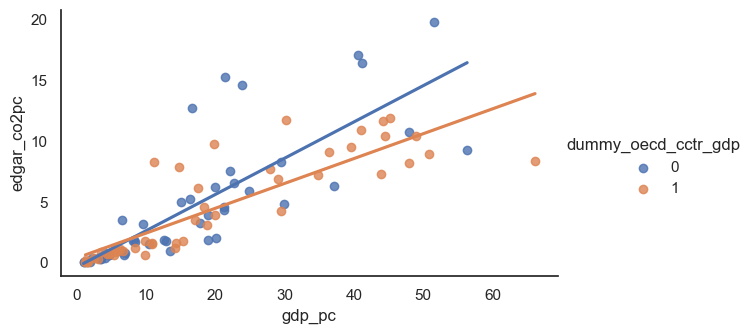

In [14]:
sns.lmplot(x='gdp_pc', y='edgar_co2pc', data=df, hue="dummy_oecd_cctr_gdp", height=3.5, aspect=1.7, ci=False)

- Mhm indeed it seems that the difference in the lines is more evident with level data.
- Let's re-run regressions, this time using (i) directly the dummy for carbon-tax revenues, (ii) the canned OLS function, (iii) the package Stargazer to nicely display our results:

In [15]:
# canned ols
res_1 = sm.OLS.from_formula('edgar_co2pc ~ gdp_pc', df).fit()
res_2 = sm.OLS.from_formula('edgar_co2pc ~ gdp_pc + dummy_oecd_cctr_gdp', df).fit()
res_3 = sm.OLS.from_formula('edgar_co2pc ~ gdp_pc*dummy_oecd_cctr_gdp', df).fit()
stargazer = Stargazer([res_1, res_2, res_3])
stargazer

- Nice table!! And indeed we get slightly stronger results for our interaction term in column 3, which is now statistically significant at the 5-% level.
- You can take this table as a rule of thumb to present your results with interaction terms. You should always show (i) your baseline specification (column 1), your baseline specification augmented with the added variable of interest (column 2), your baseline specification augmented with your added variable and the interaction term of interest (column 3). You should comment these columns step by step, and saying whether your coefficient estimates are in line with your logic and expectations, and if not come up with explanations of why that might be the case.
- So let's **interpret this table** by relying on the reasoning explained above. The table above reports regression results for the relationship between GDP per capita, expressed in thousands of US dollars per year, and CO2 emissions per capita, expressed in tonnes of CO2 per year, obtained with a cross-sectional sample of 94 countries. **Column 1** reports the baseline results. The coefficient estimate of 0.239 indicates that, on average, if GDP per capita increases by 1000 US dollars, we'd expect CO2 emissions per capita to increase by 0.239 tonnes. This result is statistically significant at the 1-% level. Looking at the Adjusted R-Squared, we can say that GDP per capita explains around 64% of the variation of CO2 emissions per capita, which is quite high. These results could be subject to omitted-variable bias, as countries with higher GDP per capita might also have higher carbon taxes, which in turn affect CO2 emissions. As with a carbon tax individuals consume less carbon-intensive goods than what they would normally do, we expect that our result of column 1 underestimates the real effect (we have a downward bias). We control for this issue with the specification of **column 2**, in which we include a dummy that equals one for countries above the median of an index for carbon-tax revenues, and 0 otherwise. The negative and statistically significant coefficient estimate of -0.953 suggest that indeed countries with higher carbon-tax revenues have lower emissions. This in turn hints that carbon-tax revenues can be a source of endogeneity in our sample. In addition, as the coefficient estimate of GDP per capita moves from 0.239 in column 1 to 0.242 in column 2, we indeed confirm that in column 1 we might have underestimated the effect. Furthermore, the high value for the F statistic suggests that the estimates for both regressors in our model are jointly significant. So the less-biased specification of column 2 suggest that, on average, if GDP per capita increases by 1000 US dollars, we'd expect CO2 emissions per capita to increase by 0.242 tonnes.
- We'll leave it as an exercise for you to comment column 3.